# plotly.py

- Plotly Expressよりも低レベルなAPI
- Plotlyと表記されることもある(ここでは `plotly.js` と分類するために `plotly.py` と表記)

In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def make_resample_df(df, rule):
    new_df = df.loc[:, "price"].resample(rule, label="right").ohlc()
    new_df.loc[:, "volume"] = df.loc[:, "size"].resample(rule, label="right").sum()
    new_df.loc[:, "instrument"] = df.loc[df.index[0], "instrument"]
    new_df.loc[:, "pct_change"] = new_df.loc[:, "close"].pct_change()
    new_df.reset_index(inplace=True)
    new_df.loc[:, "day_name"] = new_df.loc[:, "datetime"].dt.day_name()
    return new_df


btceur = pd.read_pickle("../data/binance_btc-eur.pkl")
etheur = pd.read_pickle("../data/binance_eth-eur.pkl")
resample_btceur = make_resample_df(btceur, "1H")
resample_etheur = make_resample_df(etheur, "1H")

## figureオブジェクト

- 描画領域全体（図）のオブジェクト
- Matplotlibのfigureに近い
- `Figure` クラスや `make_subplots` 関数などから生成

> https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html#id0

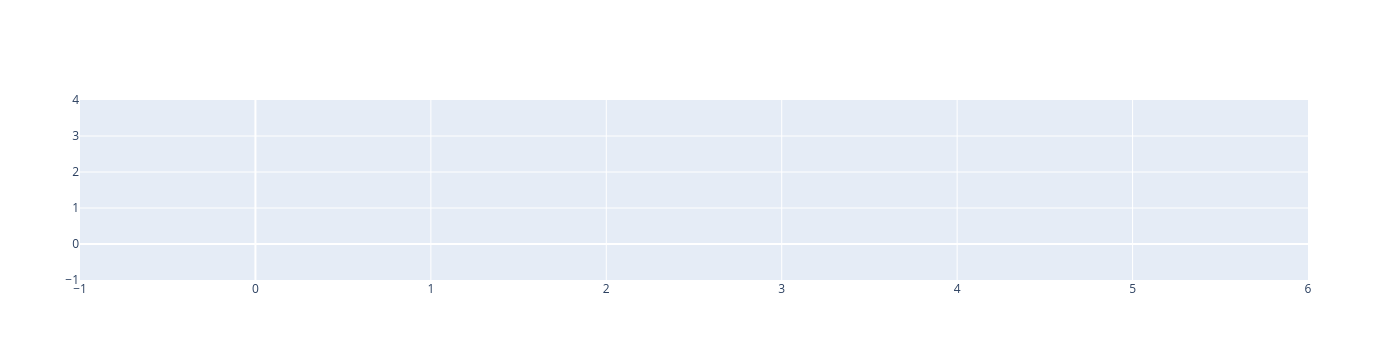

In [3]:
fig = go.Figure()
fig.show()

## traceオブジェクト

- グラフの要素
- `Scatter` （散布図、折れ線グラフ）、 `Bar` （棒グラフ）などさまざまなTraceを生成するクラスがある
  - https://plotly.com/python-api-reference/plotly.graph_objects.html#simple-traces
- 最終的には `plotly.js` に対してJSON形式で渡される

In [4]:
trace = go.Scatter(
    x=resample_btceur.loc[:, "datetime"], y=resample_btceur.loc[:, "close"]
)
trace

Scatter({
    'x': array([datetime.datetime(2022, 3, 1, 1, 0, tzinfo=<UTC>),
                datetime.datetime(2022, 3, 1, 2, 0, tzinfo=<UTC>),
                datetime.datetime(2022, 3, 1, 3, 0, tzinfo=<UTC>), ...,
                datetime.datetime(2022, 3, 28, 22, 0, tzinfo=<UTC>),
                datetime.datetime(2022, 3, 28, 23, 0, tzinfo=<UTC>),
                datetime.datetime(2022, 3, 29, 0, 0, tzinfo=<UTC>)], dtype=object),
    'y': array([38882.82, 38611.4 , 38525.47, ..., 43424.16, 43303.69, 42893.96])
})

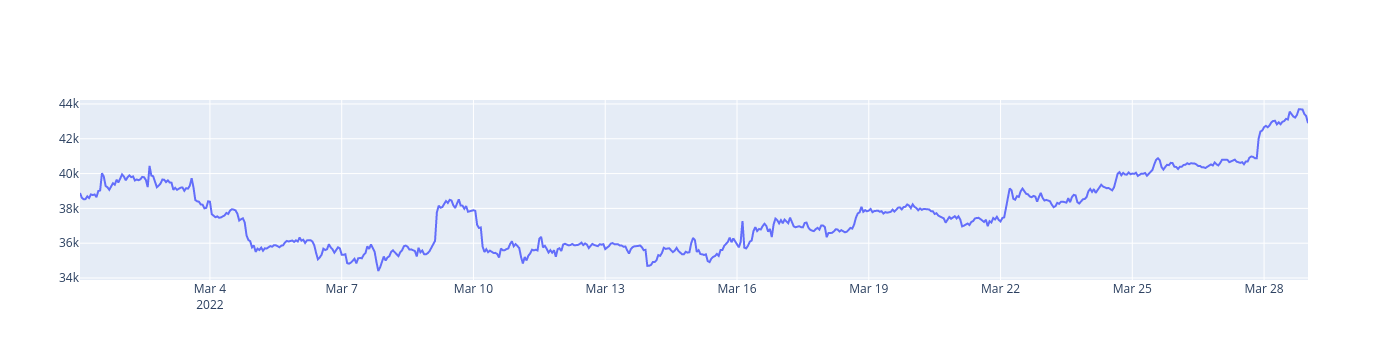

In [5]:
fig = go.Figure(trace)
fig.show()

複数のtraceを渡す場合はリストに格納します

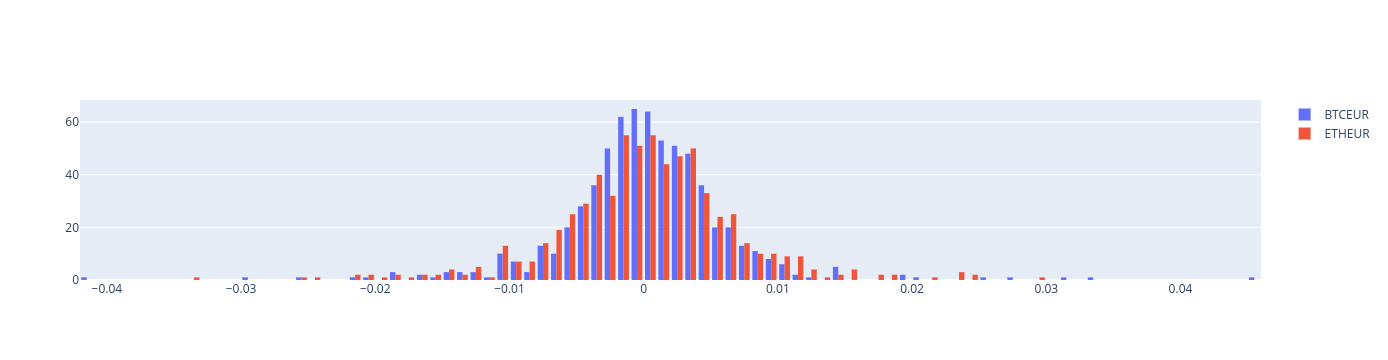

In [6]:
go.Figure(
    [
        go.Histogram(x=resample_btceur.loc[:, "pct_change"], name="BTCEUR"),
        go.Histogram(x=resample_etheur.loc[:, "pct_change"], name="ETHEUR"),
    ]
)

または `add_trace` メソッドを実行して追加します

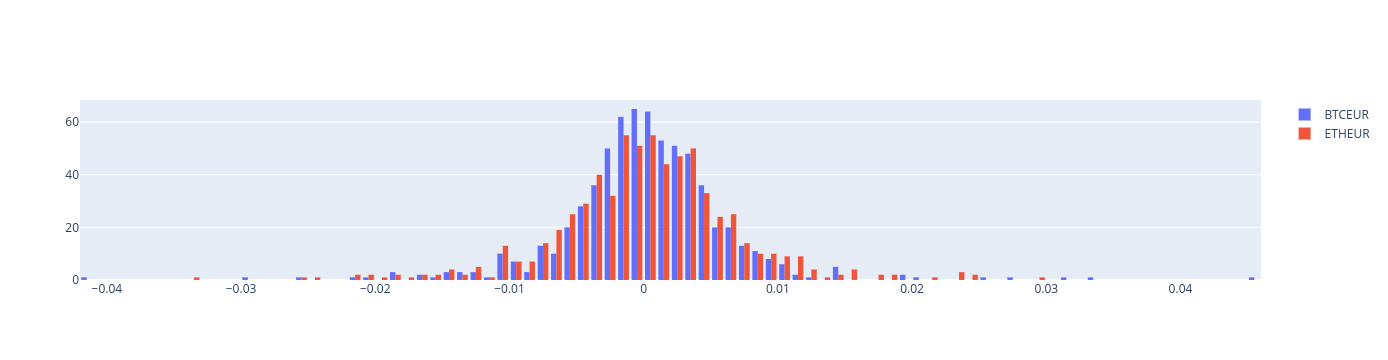

In [7]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=resample_btceur.loc[:, "pct_change"], name="BTCEUR"))
fig.add_trace(go.Histogram(x=resample_etheur.loc[:, "pct_change"], name="ETHEUR"))
fig.show()

## layoutオブジェクト

- グラフのレイアウト
    - タイトル
    - サイズ
    - 軸
    - etc

layoutオブジェクトは `Figure` クラスの `layout` 引数や、figureオブジェクトの `update_layout` メソッドなどから設定します

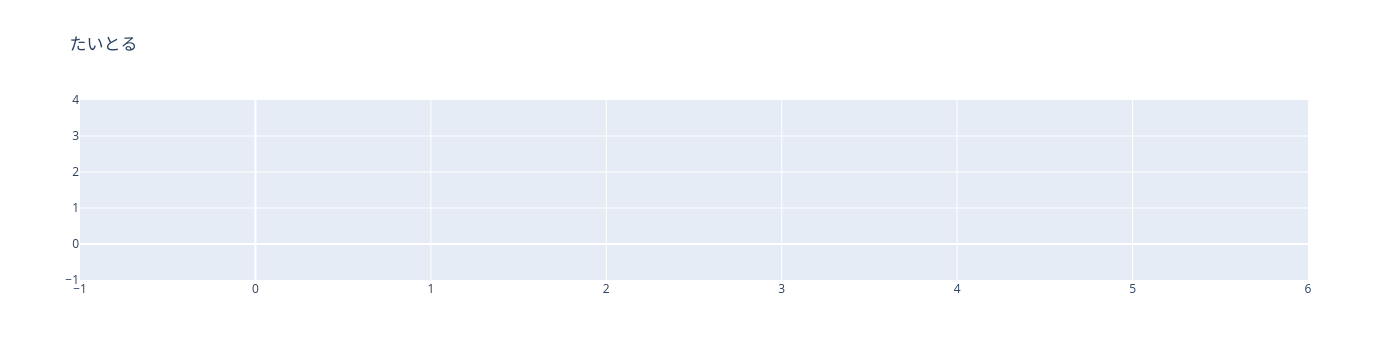

In [8]:
fig = go.Figure(layout=go.Layout(title={"text": "たいとる"}))
fig.show()

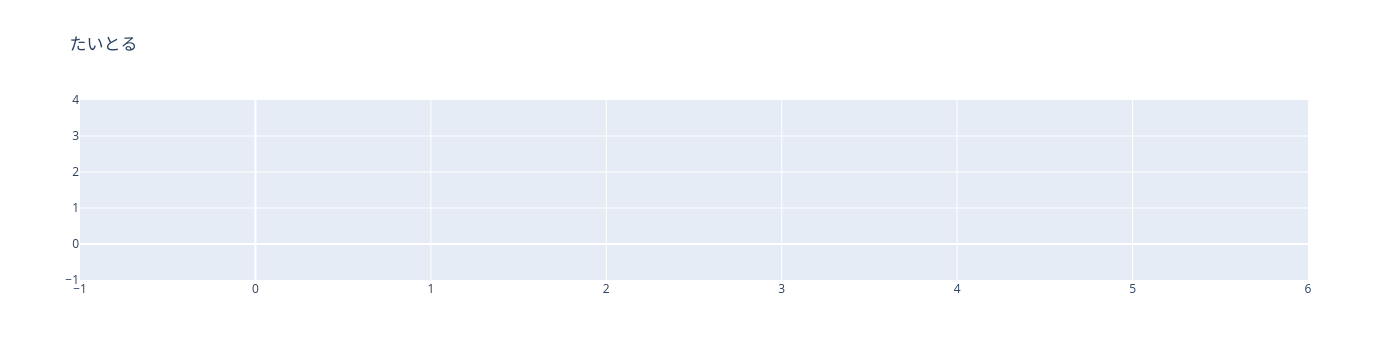

In [9]:
fig.update_layout(height=300, width=300)

## サブプロット

複数のサブプロットに描画する場合は`make_subplots` 関数を利用します

traceの引数 `row` に行番号、 `col` に列番号を渡します

- shared_xaxes: X軸を共有
- vertical_spacing: 余白

Plotly Expressにはない、ローソク足( `Candlestick` )が利用できます[^1]

[^1]: plotly.py 5.7.0時点

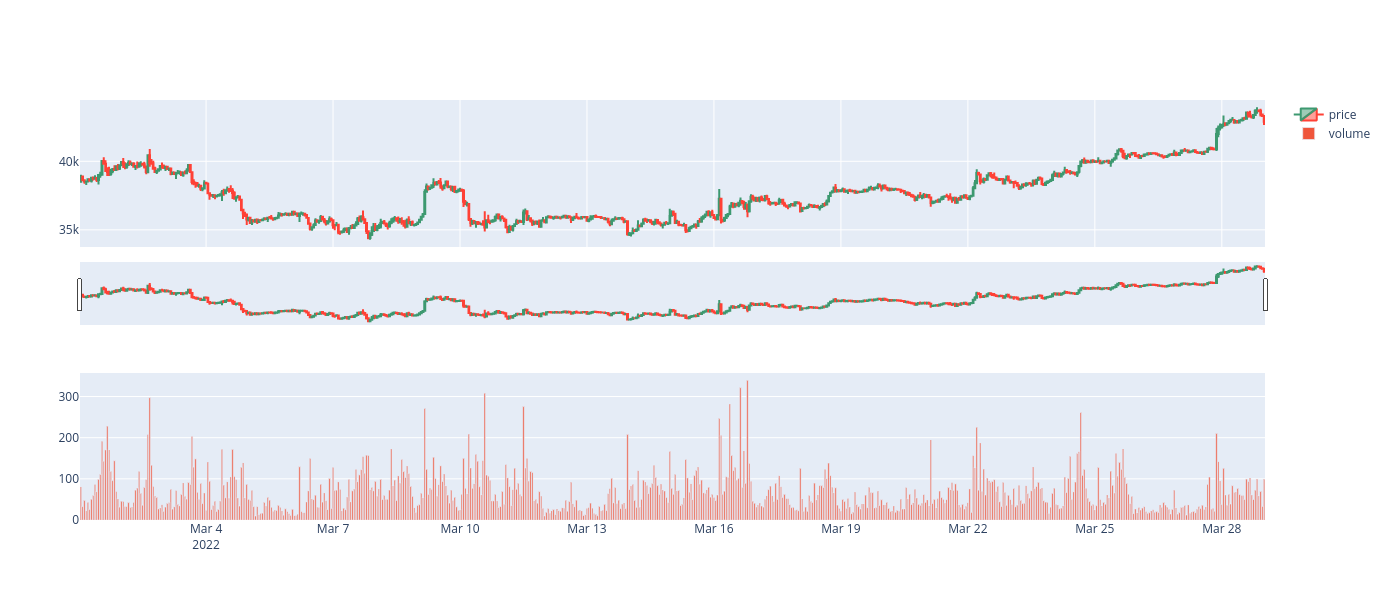

In [10]:
t, o, h, l, c, v = resample_btceur.loc[
    :, ["datetime", "open", "high", "low", "close", "volume"]
].values.T
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.3)
fig.add_trace(go.Candlestick(x=t, open=o, high=h, low=l, close=c, name="price"), row=1, col=1)
fig.add_trace(go.Bar(x=t, y=v, name="volume"), row=2, col=1)
fig.update_layout(height=600)
fig.show()

specsは各サブプロットの設定情報が格納されます

2次元のリスト構造をもち、リストの要素が行と列に対応します

`secondary_y` を `True` にすることで、Y軸を2つもつことができます

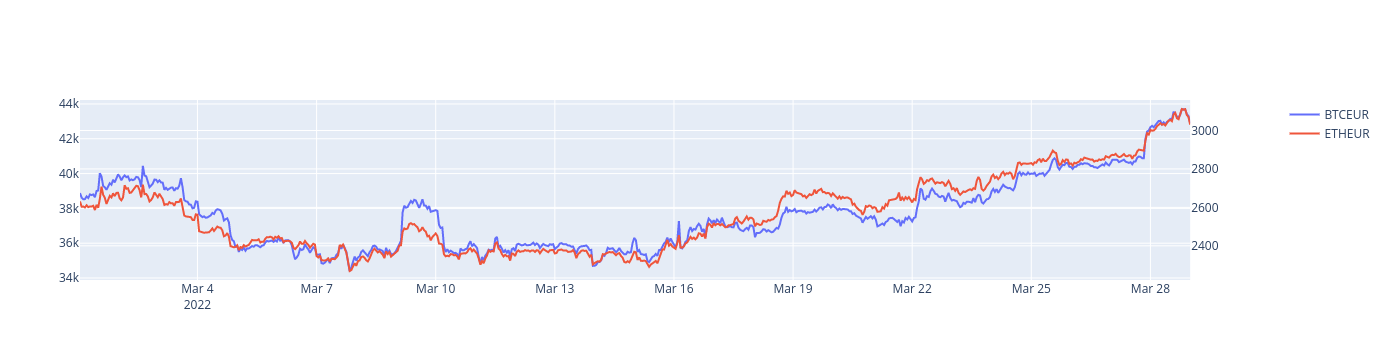

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=resample_btceur.loc[:, "datetime"], y=resample_btceur.loc[:, "close"], name="BTCEUR")
)
fig.add_trace(
    go.Scatter(x=resample_etheur.loc[:, "datetime"], y=resample_etheur.loc[:, "close"], name="ETHEUR"),
    secondary_y=True
)

plotly.pyでは、前述のローソク足のほか、Plotly Expressでは表現できない複雑なグラフを描画できます

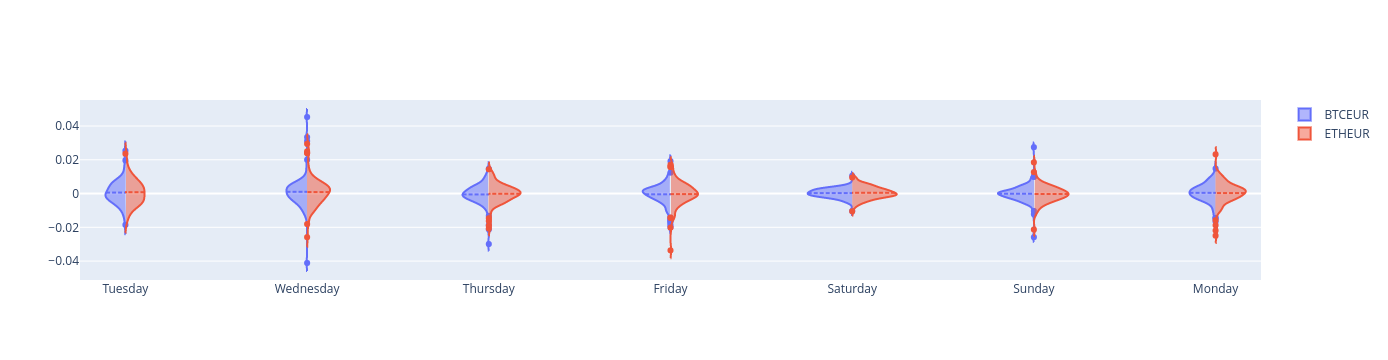

In [12]:
fig = go.Figure()
fig.add_trace(
    go.Violin(x=resample_btceur.loc[:, "day_name"],
              y=resample_btceur.loc[:, "pct_change"],
              side="negative",
              name="BTCEUR"
             )
)
fig.add_trace(
    go.Violin(x=resample_etheur.loc[:, "day_name"],
              y=resample_etheur.loc[:, "pct_change"],
              side="positive",
              name="ETHEUR"
             )
)
fig.update_traces(meanline_visible=True)
fig.show()